# Investigating New-Index/Old-Index

In [357]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns


pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Import Data

In [358]:
client_test = pd.read_csv('./data/test/client_test.csv')
invoice_test = pd.read_csv('./data/test/invoice_test.csv')


In [359]:
client_train = pd.read_csv('./data/train/client_train.csv')
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.00
1,69,train_Client_1,11,107,29/05/2002,0.00
2,62,train_Client_10,11,301,13/03/1986,0.00
3,69,train_Client_100,11,105,11/07/1996,0.00
4,62,train_Client_1000,11,303,14/10/2014,0.00


In [360]:
invoice_train = pd.read_csv('./data/train/invoice_train.csv')



/var/folders/9x/vhdwn1fd0cldzwf9fnftwf980000gn/T/ipykernel_24071/2798116946.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  invoice_train = pd.read_csv('./data/train/invoice_train.csv')


## Calculate the difference between Old and New Index

Todo: calculate with or withoud negatives!


In [361]:
# calculate difference between new and old index

def calc_index_diff(x):
    if (x['old_index']> x['new_index']): #& (x['old_index']>95000):
        return x['new_index'] #100000-x['old_index']+ x['new_index']
    else: 
        return x['new_index']-x['old_index']

invoice_train['index_diff'] = invoice_train.apply(calc_index_diff, axis=1)



## High Month Numbers

We recognized, that there are some observations, where the row numbers are huge (eg. 600.000). That doesn't make sense at all! 

We defined a threshold by 36 months (3 years!) and count the values: There 2090 observations, and 632 clients, where the month number is higher than 36!




In [362]:
# total amount of rows where month_number > 36
invoice_train[invoice_train['months_number']>=36].count()

# total amount of unique clients where month_number>36
invoice_train[invoice_train['months_number']>=36].nunique()

client_id                632
invoice_date             845
tarif_type                 9
counter_number           697
counter_statue             8
counter_code              22
reading_remarque           6
counter_coefficient        6
consommation_level_1     339
consommation_level_2     821
consommation_level_3     332
consommation_level_4      16
old_index                678
new_index               1900
months_number           1334
counter_type               2
index_diff              1668
dtype: int64

<Axes: xlabel='counter_type', ylabel='months_number'>

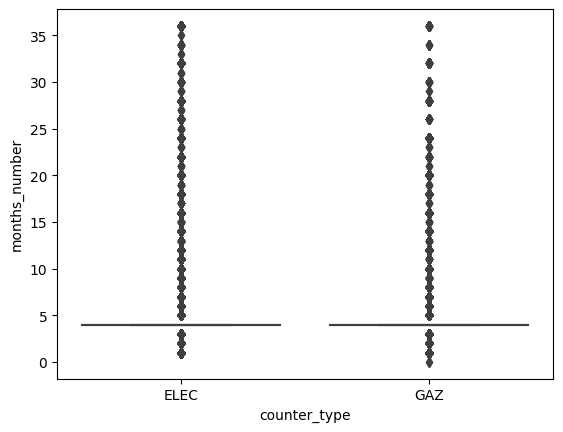

In [363]:
sns.boxplot(x='counter_type', y='months_number', data = invoice_train[invoice_train['months_number']<=36])

In [364]:
# try to figuer out manually, which clients are outliers (month_numbers)
# outliers = ['train_Client_99465', 'train_Client_67670', 'train_Client_131550', 'train_Client_131075', 'train_Client_14780' ]

# months = invoice_train.sort_values('months_number', ascending=False)
# months = months[~months['client_id'].isin(outliers)]
# months[['client_id', 'months_number']]

In [365]:
# drop outliers!
# only get rows, where months <= 36
invoice_train_max_month = invoice_train[invoice_train['months_number']<=36]

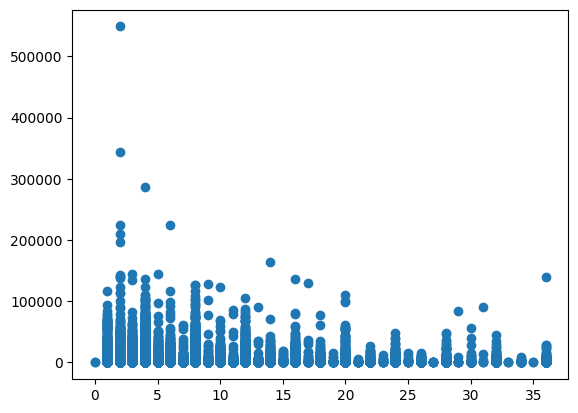

In [366]:
plt.scatter(x= invoice_train_max_month['months_number'], y=invoice_train_max_month['index_diff'])

## Invoice Data - Datatype changee to datetime()

In [367]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])

invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 17 columns):
 #   Column                Dtype         
---  ------                -----         
 0   client_id             object        
 1   invoice_date          datetime64[ns]
 2   tarif_type            int64         
 3   counter_number        int64         
 4   counter_statue        object        
 5   counter_code          int64         
 6   reading_remarque      int64         
 7   counter_coefficient   int64         
 8   consommation_level_1  int64         
 9   consommation_level_2  int64         
 10  consommation_level_3  int64         
 11  consommation_level_4  int64         
 12  old_index             int64         
 13  new_index             int64         
 14  months_number         int64         
 15  counter_type          object        
 16  index_diff            int64         
dtypes: datetime64[ns](1), int64(13), object(3)
memory usage: 580.6+ MB


In [386]:
invoice_train['month'] = invoice_train['invoice_date'].dt.month

invoice_train['day'] = invoice_train['invoice_date'].dt.day

invoice_train['year'] = invoice_train['invoice_date'].dt.year

invoice_train['day_of_week'] = invoice_train['invoice_date'].dt.dayofweek

invoice_train['weekend'] = np.where(invoice_train['day_of_week'].isin([6]), 1,0)
invoice_train.head()

invoice_train['weekend'].value_counts()

weekend
0    4209549
1     267200
Name: count, dtype: int64

## Investigating Clients

In [382]:
# investigating clients

def investigate_client(client_id):
    is_fraud = False
    target = client_train[client_train['client_id'] == client_id]['target']
    if target.values[0] == 1.0:
        is_fraud = True
        print('The client with id:', client_id, 'has made a fraud')
    else:
        print('The client with id:', client_id, 'has NOT made a fraud')
    
    client= invoice_train[invoice_train['client_id']== client_id]
    client = client.sort_values('invoice_date')
    if client['counter_type'].nunique() == 2:
        gaz = client[client['counter_type']=='GAZ']
        elec = client[client['counter_type']=='ELEC']
        return gaz[['client_id','invoice_date', 'old_index', 'new_index', 'index_diff', 'consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'months_number', 'counter_type']], elec[['client_id','invoice_date', 'old_index', 'new_index', 'index_diff', 'consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'months_number', 'counter_type']]
    else:
        return client[['client_id','invoice_date', 'old_index', 'new_index', 'index_diff', 'consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'months_number', 'counter_type']], pd.DataFrame()

In [383]:
# client_df1, client_df2 = investigate_client('train_Client_99980')
client_df1, client_df2 = investigate_client('train_Client_14780')
client_df1.sort_values('months_number', ascending=False)

The client with id: train_Client_14780 has made a fraud


,client_id,invoice_date,old_index,new_index,index_diff,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,months_number,counter_type
1352899,train_Client_14780,2019-03-09,0,364569,364569,3,1557,0,0,365767,GAZ
1352871,train_Client_14780,2019-02-08,0,361336,361336,3,4202,0,0,364569,GAZ
1352789,train_Client_14780,2019-10-06,0,359968,359968,3,1778,0,0,361336,GAZ
1352764,train_Client_14780,2019-03-05,0,356645,356645,3,4319,0,0,359968,GAZ
1352884,train_Client_14780,2019-04-03,0,355074,355074,3,2042,0,0,356645,GAZ
...,...,...,...,...,...,...,...,...,...,...,...
1352742,train_Client_14780,2011-02-11,189200,191673,2473,2473,0,0,0,1,GAZ
1352740,train_Client_14780,2011-02-09,184353,186657,2304,2304,0,0,0,1,GAZ
1352795,train_Client_14780,2011-02-08,182437,184353,1916,1916,0,0,0,1,GAZ
1352902,train_Client_14780,2011-02-06,177750,180282,2532,2532,0,0,0,1,GAZ


In [320]:
client_df2.head(30)

,client_id,invoice_date,old_index,new_index,index_diff,months_number,counter_type
1352846,train_Client_14780,2005-12-23,0,87212,87212,90468,ELEC
1352847,train_Client_14780,2006-04-05,0,90468,90468,96232,ELEC
1352849,train_Client_14780,2006-08-28,0,96232,96232,2585,ELEC
1352851,train_Client_14780,2006-12-25,0,2585,2585,8572,ELEC
1352853,train_Client_14780,2007-03-05,0,8572,8572,20652,ELEC
1352836,train_Client_14780,2007-08-28,0,20652,20652,34025,ELEC
1352834,train_Client_14780,2007-12-28,0,34025,34025,48221,ELEC
1352762,train_Client_14780,2008-02-05,0,48221,48221,66223,ELEC
1352842,train_Client_14780,2008-08-27,0,66223,66223,86169,ELEC
1352840,train_Client_14780,2008-12-26,0,86169,86169,10905,ELEC


#### Split into fraud and not-fraud

In [321]:
# 7566 clients did a fraud
fraud_client_list = client_train[client_train['target'] == 1]['client_id']

In [322]:
not_fraud_client_list = client_train[client_train['target'] == 0]['client_id'].to_list()
not_fraud_client_list

invoice_train_nf = invoice_train[invoice_train['client_id'].isin(not_fraud_client_list)]


comparison, if the fraud/not-fraud have an impact to the months_numbers, grouped by GAZ and ELEC


<Axes: xlabel='counter_type', ylabel='months_number'>

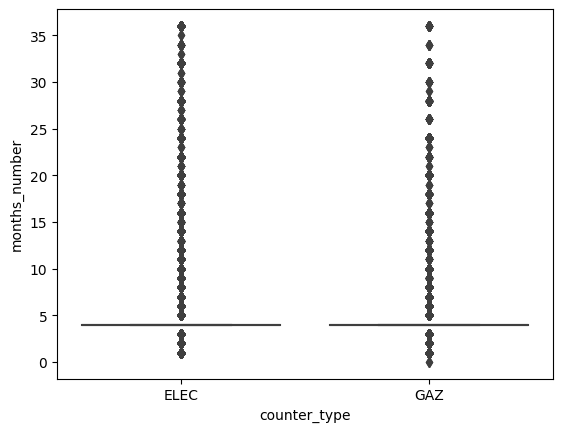

In [323]:
sns.boxplot(x='counter_type', y='months_number', data = invoice_train_nf[invoice_train_nf['months_number']<=36])

<Axes: xlabel='counter_type', ylabel='months_number'>

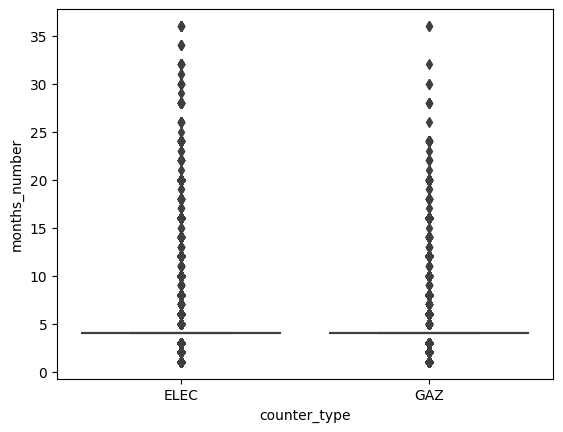

In [324]:
invoice_train_f = invoice_train[invoice_train['client_id'].isin(fraud_client_list)]
sns.boxplot(x='counter_type', y='months_number', data = invoice_train_f[invoice_train_f['months_number']<=36])

## Looking at the target


In [325]:
merged_df_train = invoice_train_max_month.merge(client_train, on="client_id", how="left")
merged_df_train

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,...,old_index,new_index,months_number,counter_type,index_diff,disrict,client_catg,region,creation_date,target
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,...,14302,14384,4,ELEC,82,60,11,101,31/12/1994,0.00
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,...,12294,13678,4,ELEC,1384,60,11,101,31/12/1994,0.00
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,...,14624,14747,4,ELEC,123,60,11,101,31/12/1994,0.00
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,...,14747,14849,4,ELEC,102,60,11,101,31/12/1994,0.00
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,...,15066,15638,12,ELEC,572,60,11,101,31/12/1994,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4474885,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,...,3197,3732,8,ELEC,535,60,11,101,22/12/1993,0.00
4474886,train_Client_99998,2005-12-19,10,1253571,0,202,6,1,200,6,...,3732,3938,4,ELEC,206,60,11,101,22/12/1993,0.00
4474887,train_Client_99999,1996-09-25,11,560948,0,203,6,1,259,0,...,13884,14143,4,ELEC,259,60,11,101,18/02/1986,0.00
4474888,train_Client_99999,1996-05-28,11,560948,0,203,6,1,603,0,...,13281,13884,4,ELEC,603,60,11,101,18/02/1986,0.00


<Axes: >

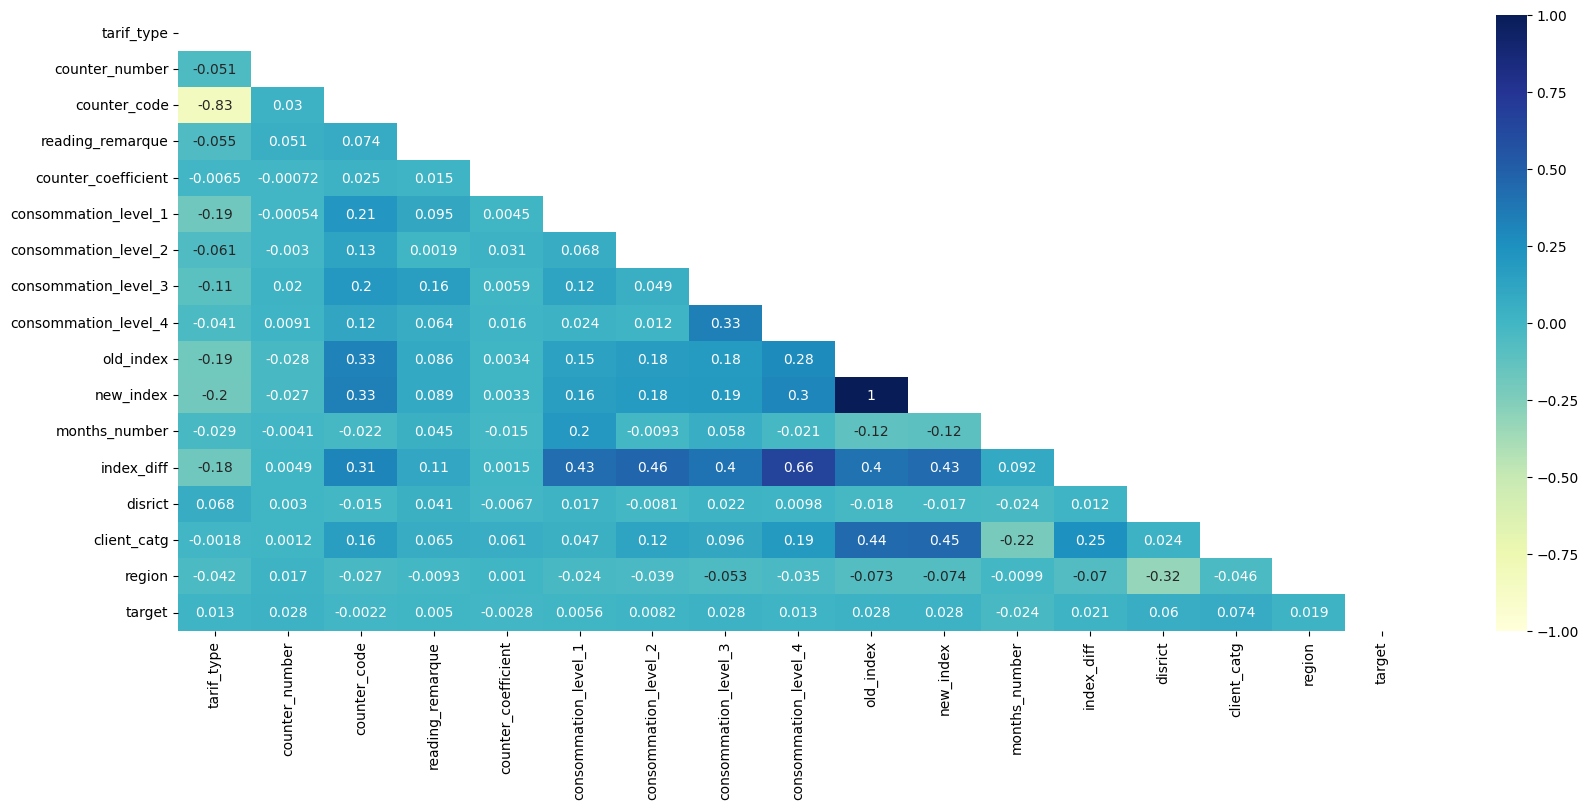

In [326]:
correlations = merged_df_train.corr(numeric_only=True)
mask = np.triu(correlations)
plt.figure(figsize=(20,8))
sns.heatmap(correlations , vmax=1, vmin=-1, annot=True, mask=mask, cmap="YlGnBu")